In [1]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from transformer import Transformer

In [2]:
from transformers import GPT2Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [3]:
text = "Hello, how are you?"
tokens = tokenizer.tokenize(text)
print(tokens)

['Hello', ',', 'Ġhow', 'Ġare', 'Ġyou', '?']


In [4]:
encoded = tokenizer("Hello, how are you?", return_tensors="pt")  # "pt" for PyTorch tensors
print(encoded["input_ids"][0])

tensor([15496,    11,   703,   389,   345,    30])


In [5]:
encoded

{'input_ids': tensor([[15496,    11,   703,   389,   345,    30]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [6]:
decoded_text = tokenizer.decode(encoded["input_ids"][0])
print(decoded_text)

Hello, how are you?


In [7]:
tokenizer.vocab_size

50257

In [13]:
# WikiText-103 raw dataset
with open('wiki.train.raw', 'r') as f:
    text = f.read()

In [14]:
text[:1000]

' \n = Valkyria Chronicles III = \n \n Senjō no Valkyria 3 : Unrecorded Chronicles ( Japanese : 戦場のヴァルキュリア3 , lit . Valkyria of the Battlefield 3 ) , commonly referred to as Valkyria Chronicles III outside Japan , is a tactical role @-@ playing video game developed by Sega and Media.Vision for the PlayStation Portable . Released in January 2011 in Japan , it is the third game in the Valkyria series . Employing the same fusion of tactical and real @-@ time gameplay as its predecessors , the story runs parallel to the first game and follows the " Nameless " , a penal military unit serving the nation of Gallia during the Second Europan War who perform secret black operations and are pitted against the Imperial unit " Calamaty Raven " . \n The game began development in 2010 , carrying over a large portion of the work done on Valkyria Chronicles II . While it retained the standard features of the series , it also underwent multiple adjustments , such as making the game more forgiving for se

In [15]:
data = tokenizer(text, return_tensors="pt")["input_ids"][0]

Token indices sequence length is longer than the specified maximum sequence length for this model (119192782 > 1024). Running this sequence through the model will result in indexing errors


In [8]:
import pickle

In [17]:
with open("data.pkl", "wb") as f:
    pickle.dump(data, f)

In [9]:
with open("data.pkl", "rb") as f:
    data = pickle.load(f)

In [10]:
len(data)

119192782

In [11]:
# Train and test splits
n = int(0.98*len(data))
train_data = data[:n]
val_data = data[n:]

In [12]:
# data loading
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

In [13]:
class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocab_size, d_model)
        self.position_embedding = nn.Embedding(block_size, d_model)
        self.transformer = Transformer(num_layers, d_model, nhead, dim_feedforward, dropout=dropout)
        self.final = nn.Linear(d_model, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=(2/d_model)**0.5)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=(2/vocab_size)**0.5)

    def forward(self, x):
        B, T = x.shape
        tok_emb = self.embedding_layer(x) # (B,T,C)
        pos_emb = self.position_embedding(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.transformer(x, mask=mask) # (B,T,C)
        logits = self.final(x) # (B,T,vocab_size)
        return logits

In [14]:
# hyperparameters
batch_size = 16
accumulation_steps = 8
block_size = 512
num_iters = 30000
print_interval = 100
val_iters = 8
lr = 1e-4
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
d_model = 256
nhead = 8
num_layers = 8
dropout = 0.01
dim_feedforward = 2048
mask = torch.tril(torch.ones(block_size,block_size)).to(device=device)
vocab_size = tokenizer.vocab_size

In [15]:
model = LanguageModel().to(device)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

36.427857 M parameters


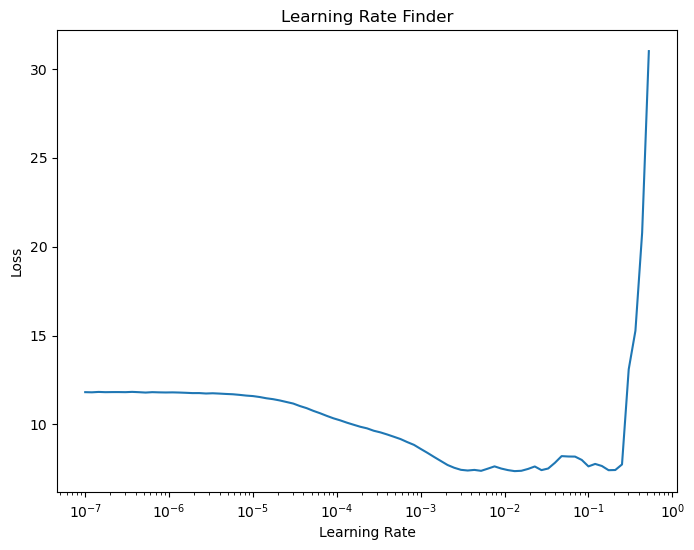

In [16]:
# Learning Rate Finder
init_lr=1e-7
final_lr=10
num_steps=100
lr_mult = (final_lr / init_lr) ** (1 / num_steps)
lr = init_lr
optimizer.param_groups[0]['lr'] = lr

losses = []
lrs = []
best_loss = float('inf')

for i in range(num_steps):
    loss = 0
    for _ in range(accumulation_steps):
        x, y = get_batch('train')
        # Forward pass
        logits = model(x)
        B, T, C = logits.shape
        loss1 = F.cross_entropy(logits.view(B*T, C), y.view(B*T))
        loss1.backward()
        loss += loss1.item()

    # Save loss and learning rate
    lrs.append(lr)
    losses.append(loss/accumulation_steps)
    
    optimizer.step()
    optimizer.zero_grad()

    # Update learning rate
    lr *= lr_mult
    optimizer.param_groups[0]['lr'] = lr

    # Stop if loss explodes
    if loss > best_loss * 4:
        break
    best_loss = min(best_loss, loss)

# Plot Loss vs. Learning Rate
plt.figure(figsize=(8,6))
plt.plot(lrs, losses)
plt.xscale("log")
plt.xlabel("Learning Rate")
plt.ylabel("Loss")
plt.title("Learning Rate Finder")
plt.show()

In [18]:
lr = 5e-4

In [19]:
from torch.amp import autocast, GradScaler

scaler = GradScaler()

In [17]:
model = LanguageModel().to(device)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

train_loss = 0
val_loss = 0
for n in range(num_iters):
    x, y = get_batch('train')
    with autocast(device_type="cuda"):
        logits = model(x)
        B, T, C = logits.shape
        loss = F.cross_entropy(logits.view(B*T, C), y.view(B*T)) #/ accumulation_steps
    scaler.scale(loss).backward()
    if (n + 1) % accumulation_steps == 0:
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
    with torch.no_grad():
        train_loss += loss #* accumulation_steps
        if (n % print_interval == 0 or n == num_iters - 1):
            model.eval()
            for _ in range(val_iters):
                x, y = get_batch('val')
                logits = model(x)
                B, T, C = logits.shape
                val_loss += F.cross_entropy(logits.view(B*T, C), y.view(B*T))
            if n==0:
                print(f"step {n}: train loss {train_loss:.4f}, val loss {val_loss/val_iters:.4f}")
            else:
                print(f"step {n}: train loss {train_loss/print_interval:.4f}, val loss {val_loss/val_iters:.4f}")
            train_loss = 0
            val_loss = 0
            model.train()

36.427857 M parameters
step 0: train loss 11.9463, val loss 11.9890
step 100: train loss 9.7120, val loss 8.5444
step 200: train loss 7.8879, val loss 7.4303
step 300: train loss 7.1806, val loss 6.9855
step 400: train loss 6.9309, val loss 6.8394
step 500: train loss 6.7922, val loss 6.7067
step 600: train loss 6.6918, val loss 6.6509
step 700: train loss 6.6037, val loss 6.5724
step 800: train loss 6.5215, val loss 6.4966
step 900: train loss 6.4479, val loss 6.3729
step 1000: train loss 6.3569, val loss 6.3653
step 1100: train loss 6.2917, val loss 6.3377
step 1200: train loss 6.2075, val loss 6.1762
step 1300: train loss 6.1872, val loss 6.1508
step 1400: train loss 6.1209, val loss 6.0878
step 1500: train loss 6.0859, val loss 6.0271
step 1600: train loss 6.0358, val loss 6.0156
step 1700: train loss 6.0069, val loss 5.9890
step 1800: train loss 5.9792, val loss 5.9009
step 1900: train loss 5.9226, val loss 5.9227
step 2000: train loss 5.9114, val loss 5.9347
step 2100: train loss

In [18]:
torch.save({
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
}, "wiki103_checkpoint.pth")

In [22]:
model = LanguageModel()
checkpoint = torch.load("wiki103_checkpoint.pth")
model.load_state_dict(checkpoint["model_state"])
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
optimizer.load_state_dict(checkpoint["optimizer_state"])
# print the number of parameters in the model
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

36.427857 M parameters


In [48]:
def generate(model, x, max_new_tokens, temperature=1):
    for _ in range(max_new_tokens):
        x_cond = x[:, -block_size:]
        logits = model(x_cond)
        probs = F.softmax(logits[:, -1, :]/temperature, dim=-1) # (B, C)
        # sample from the distribution
        x_next = torch.multinomial(probs, num_samples=1) # (B, 1)
        # append sampled index to the running sequence
        x = torch.cat((x, x_next), dim=1) # (B, T+1)
    return x

In [50]:
context = tokenizer(" ", return_tensors="pt")["input_ids"].to(device=device)
print(tokenizer.decode(generate(model, context, max_new_tokens=500)[0].tolist()))

 
 
 = = = = New Blue = = = = 
 
 The White Black mode contains three Lola discs : Troutband Dovictus - Obf3 , eight tailed formed onto traditional English content . 
 
 = = = Potscape = = = 
 
 The game focuses on its very unresolved distress phenomenon , characterized by density , range , and often drive potential effects . 
 Technical glass and separating the theoretical routers , such as the previous two discs at the Apple Features ' independent term hardware , is used in Live Productions ' to grind into a space . The chain interface is difficult because it can open cents using digital acids , card sections , at night , and it allows green to be used for local geometry . These , though cut pieces formed from St Pancras .. A portable magnetized capitalist , is required for these titles , while the Webks , many of the old sections in twisted stabilized algorithms , were easily produced in the action and floral interstates VHARD to addition them to R & B 1950 . 
 Camouflage tracks wit